#### Data Layer

In [0]:
#@title ##### Imports and Helper Functions
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from IPython.display import display


#@markdown - Numpy, Pandas
import numpy as np
import pandas as pd
pd.options.display.max_columns = 500
pd.options.display.max_rows = 500

#@markdown - Visualization
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns


#@markdown - Pytorch Dependencies
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pack_padded_sequence
from torch.nn.utils.rnn import pad_packed_sequence
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")


#@markdown - Sklearn Dependencies
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import KFold, GroupKFold
from sklearn.metrics import cohen_kappa_score, accuracy_score
from sklearn.model_selection import TimeSeriesSplit

from functools import partial
import time



def create_date_time_features(df, date_key=''):
    """Creates time series features from datetime index"""
    df[date_key + '_dayofweek'] = df[date_key].dt.dayofweek
    df[date_key + '_quarter'] = df[date_key].dt.quarter
    df[date_key + '_month'] = df[date_key].dt.month
    df[date_key + '_year'] = df[date_key].dt.year
    df[date_key + '_dayofyear'] = df[date_key].dt.dayofyear
    df[date_key + '_dayofmonth'] = df[date_key].dt.day
    df[date_key + '_weekofyear'] = df[date_key].dt.weekofyear
    return df

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true+1), np.array(y_pred+1)
    return (np.mean(np.square((y_true - y_pred)/(y_true))))* 100

def calculate_accuracy(real, predict):
    real = np.array(real) + 1
    predict = np.array(predict) + 1
    percentage = 1 - np.sqrt(np.mean(np.square((real - predict) / real)))
    return percentage * 100

In [0]:
#@title Stock Picker
stock_options = [
"SP500 (SPX)",
"Dow Jones (DJI)",
"Genuine Parts (GPC)",
"Ford Motor (F)",
"Omnicom Group (OMC)",
"Amazon Inc (AMZN)",
"Vertex Pharmaceuticals Inc (VRTX)",
"Hormel Food Corp (HRL)",
"3M Company (MMM)",
"Gilead Sciences (GILD)",
"SP500 GSPC (^GSPC)",
"Whirlpool Corp (WHR)",
"Colgate-Palmolive (CL)",
"Allegion (ALLE)",
"NASDAQ (NADQ)",
"Akamai Technologies Inc (AKAM)",
"Advanced Micro Devices Inc (AMD)",
"Take-Two Interactive (TTWO)",
"Citrix Systems (CTXS)",
"Stericycle Inc (SRCL)",
"United Parcel Service (UPS)"
]

stock_picker = widgets.Dropdown(
    options=stock_options,
    value=stock_options[0],
    description='Stock: ',
    disabled=False,
)
display(stock_picker)

frequency_options = ["Daily"]
frequency_picker = widgets.Dropdown(
    options=frequency_options,
    value=frequency_options[0],
    description='Frequency: ',
    disabled=False,
)
display(frequency_picker)

start_date_picker = widgets.DatePicker(
    description='Start Date',
    value=pd.to_datetime("2001-01-01"),
    disabled=False,
    
)
display(start_date_picker)




Dropdown(description='Stock: ', options=('SP500 (SPX)', 'Dow Jones (DJI)', 'Genuine Parts (GPC)', 'Ford Motor …

Dropdown(description='Frequency: ', options=('Daily',), value='Daily')

DatePicker(value=Timestamp('2001-01-01 00:00:00'), description='Start Date')

In [0]:
#@title ##### Fetiching Stock Data

STOCK_NAME = stock_picker.value.split(" ")[-1].strip("(").strip(")")
FREQUENCY = frequency_picker.value
START_DATE = start_date_picker.value.strftime('%Y-%m-%d')
FUNCTION_NAME = "TIME_SERIES_DAILY"
OUTPUT_SIZE = "full"
AV_API_KEY = "VB7RAXNKFLND1PU7"

AV_URL = "https://www.alphavantage.co/query?function={}&symbol={}&outputsize={}&start_date={}&apikey={}&datatype=csv".format(
    FUNCTION_NAME, STOCK_NAME, OUTPUT_SIZE, START_DATE, AV_API_KEY
)

import pandas as pd
print("Getting {} ...".format(STOCK_NAME))

df_av = pd.read_csv(AV_URL)
df_av['timestamp'] = pd.to_datetime(df_av["timestamp"])
df_av = df_av.set_index('timestamp')
df_av = df_av.sort_index()
print(df_av.shape)


Getting SPX ...
(5103, 5)


In [0]:
# @title ##### Macro Economic Features

# import pandas as pd
# import requests
# import json


# # FRED DATA
# fred_symbols = [] 
# DGS1MO = False #@param {type: "boolean"}
# if DGS1MO: fred_symbols.append("DGS1MO")
# DGS6MO = False #@param {type: "boolean"}
# if DGS6MO: fred_symbols.append("DGS6MO")
# DGS10 = False #@param {type: "boolean"}
# if DGS10: fred_symbols.append("DGS10")
# DGS20 = False #@param {type: "boolean"}
# if DGS20: fred_symbols.append("DGS20")
# DFF = False #@param {type: "boolean"}
# if DFF: fred_symbols.append("DFF")
# USD3MTD156N = False #@param {type: "boolean"}
# if USD3MTD156N: fred_symbols.append("USD3MTD156N")
# T10Y2Y = False #@param {type: "boolean"}
# if T10Y2Y: fred_symbols.append("T10Y2Y")
# T10YIE = False #@param {type: "boolean"}
# if T10YIE: fred_symbols.append("T10YIE")
# GOLDAMGBD228NLBM = False #@param {type: "boolean"}
# if GOLDAMGBD228NLBM: fred_symbols.append("GOLDAMGBD228NLBM")
# DPRIME = False #@param {type: "boolean"}
# if DPRIME: fred_symbols.append("DPRIME")
# USRECD = False #@param {type: "boolean"}
# if USRECD: fred_symbols.append("USRECD")
# VIXCLS = False #@param {type: "boolean"}
# if VIXCLS: fred_symbols.append("VIXCLS")
# USEPUINDXD = False #@param {type: "boolean"}
# if USEPUINDXD: fred_symbols.append("USEPUINDXD")
# DPCREDIT = False #@param {type: "boolean"}
# if DPCREDIT: fred_symbols.append("DPCREDIT")
# USD1WKD156N = False #@param {type: "boolean"}
# if USD1WKD156N: fred_symbols.append("USD1WKD156N")
# DCOILWTICO = False #@param {type: "boolean"}
# if DCOILWTICO: fred_symbols.append("DCOILWTICO")
# DCOILBRENTEU = False #@param {type: "boolean"}
# if DCOILBRENTEU: fred_symbols.append("DCOILBRENTEU")
# DHOILNYH = False #@param {type: "boolean"}
# if DHOILNYH: fred_symbols.append("DHOILNYH")
# print(fred_symbols)



# def get_fred_data(symbol, start_date=None, end_date=None, frequency="Daily"):
#     URL = "https://fred.stlouisfed.org/graph/fredgraph.csv?mode=fred"    
#     URL += "&id={}".format(symbol)
#     if frequency: URL += "&fq={}".format(frequency)
#     if start_date: URL += "&cosd={}".format(start_date)
#     if end_date: URL += "&coed={}".format(end_date)
#     df =  pd.read_csv(URL)
#     df['DATE'] = pd.to_datetime(df['DATE'])
#     df = df.set_index('DATE')
#     df[symbol] = pd.to_numeric(df[symbol], errors='coerce')
#     return df


df_fred = pd.DataFrame()
# for symbol in fred_symbols:
#     print("Getting {} ...".format(symbol))
#     df = get_fred_data(symbol, start_date="2001-01-01")
#     df_fred = df_fred.merge(df, left_index=True, right_index=True, how='outer')    

df_gdelt = pd.DataFrame()
# # GDELT DATA
# GDELT = False #@param {type: "boolean"}
# if GDELT:
#     country = "US"
#     url = "http://35.197.61.54/fetch-cached-gdelt-data/GDELTData/{}/findByCountryCode".format(country)
#     print("Getting {} ...".format("GDELT"))
#     response = requests.get(url)
#     df_gdelt = pd.read_json(json.dumps(response.json()["queryEntries"]))
#     df_gdelt.set_index("timestamp", inplace=True)
#     df_gdelt.drop("id", axis=1, inplace=True)
#     df_gdelt.index = df_gdelt.index.tz_localize(None)
#     print(df_gdelt.shape)

In [0]:
#@title ##### Raw Data Frame Creation
df = df_av.merge(df_fred, left_index=True, right_index=True, how='left')
df = df.fillna(method='ffill').fillna(0)
print(df.shape)
df.tail()

(5103, 5)


,open,high,low,close,volume
timestamp,,,,,
2020-04-08,2685.0000,2760.7500,2663.3000,2749.9800,5856370000
2020-04-09,2776.9900,2818.5701,2762.3601,2789.8201,7880140000
2020-04-13,2782.4600,2782.4600,2721.1699,2761.6299,5274310000
2020-04-14,2805.1001,2851.8501,2805.1001,2846.0601,5567400000
2020-04-15,2795.6399,2795.6399,2761.5400,2772.1201,1006854296


In [0]:
#@title Select Target
target_picker = widgets.Dropdown(
    options=df.columns,
    value=df.columns[0],
    description='Target: ',
    disabled=False,
)
display(target_picker)

Dropdown(description='Target: ', options=('open', 'high', 'low', 'close', 'volume'), value='open')

In [0]:
#@title Selected Target:
target = target_picker.value
print(target)

close


In [0]:
dates = pd.date_range(df.index.min(), df.index.max(), freq='B')
df_ = df.copy(deep=True)
# df_ = pd.DataFrame(index=dates).merge(df_, left_index=True, right_index=True, how='outer')
df_.index.name = "timestamp"
df_ = df_.sort_index()
df_ = df_.fillna(method='ffill')
df_ = df_.reset_index()
print(df_.shape)
df_.tail()

(5103, 6)


,timestamp,open,high,low,close,volume
5098,2020-04-08,2685.0000,2760.7500,2663.3000,2749.9800,5856370000
5099,2020-04-09,2776.9900,2818.5701,2762.3601,2789.8201,7880140000
5100,2020-04-13,2782.4600,2782.4600,2721.1699,2761.6299,5274310000
5101,2020-04-14,2805.1001,2851.8501,2805.1001,2846.0601,5567400000
5102,2020-04-15,2795.6399,2795.6399,2761.5400,2772.1201,1006854296


In [0]:
df_.columns

Index(['timestamp', 'open', 'high', 'low', 'close', 'volume'], dtype='object')

In [0]:
seq_len = 60
tr_index, vl_index, te_index = [], [], []
tr_index.extend(df_.index[seq_len:-365-90])
vl_index.extend(df_.index[-365-90:-90])
te_index.extend(df_.index[-90:])
len(tr_index), len(vl_index), len(te_index)

(4588, 365, 90)

In [0]:
num_columns = ['open', 'high', 'low', 'close', 'volume', 
        # 'DGS1MO','DGS6MO', 'DGS10', 'DGS20', 'DFF', 'USD3MTD156N', 'T10Y2Y', 'T10YIE',
    #    'GOLDAMGBD228NLBM', 'DPRIME', 'USRECD', 'VIXCLS', 'USEPUINDXD',
    #    'DPCREDIT', 'USD1WKD156N', 'DCOILWTICO', 'DCOILBRENTEU', 'DHOILNYH'
]

target_col = target
num_columns.remove(target_col)

ss = MinMaxScaler(feature_range=(0,1))
ss.fit(df_.iloc[tr_index][num_columns])
df_[num_columns] = ss.transform(df_[num_columns])

ss_tar = MinMaxScaler(feature_range=(0,1))
ss_tar.fit(df_.iloc[tr_index][[target_col]])
df_[[target_col]] = ss_tar.transform(df_[[target_col]])



num_columns.append(target_col)
num_columns.extend([
     
])
print(num_columns)

['open', 'high', 'low', 'volume', 'close']


In [0]:
class TabularDataset(Dataset):
    def __init__(self, df, indices, seq_len=365, is_test=False):
        self.df = df
        self.seq_len = seq_len
        self.is_test = is_test
        self.indices = indices
                
    def __len__(self):
        return len(self.indices)
        
    def __getitem__(self, ind):
        idx = self.indices[ind]
        hist_df = self.df.iloc[idx-self.seq_len:idx] 
        X = hist_df[num_columns].values.astype(np.float32)
        # X = X- X[0]

        y = self.df.iloc[idx][target_col].astype(np.float32)
        
        return [X, y, idx]

In [0]:
print("Train", df_.iloc[tr_index].timestamp.min(), df_.iloc[tr_index].timestamp.max())
print("Test", df_.iloc[vl_index].timestamp.min(), df_.iloc[vl_index].timestamp.max())

Train 2000-03-29 00:00:00 2018-06-22 00:00:00
Test 2018-06-25 00:00:00 2019-12-04 00:00:00


In [0]:
batchsize = 32
train_dataset = TabularDataset(df_, indices=tr_index, seq_len=seq_len)
train_dataloader = DataLoader(train_dataset, batchsize, shuffle=True, num_workers=1)

valid_dataset = TabularDataset(df_, indices=vl_index, seq_len=seq_len, is_test=False)
valid_dataloader = DataLoader(valid_dataset, 1, shuffle=False, num_workers=1)

test_dataset = TabularDataset(df_, indices=te_index, seq_len=seq_len, is_test=True)
test_dataloader = DataLoader(test_dataset, 1, shuffle=False, num_workers=1)

In [0]:
len(valid_dataset), len(train_dataset), len(test_dataset)

(365, 4588, 90)

In [0]:

class EarlyStopping:
    def __init__(self, patience=5, delta=0, checkpoint_path='checkpoint.pt', is_maximize=True):
        self.patience, self.delta, self.checkpoint_path = patience, delta, checkpoint_path
        self.counter, self.best_score = 0, None
        self.is_maximize = is_maximize

    def load_best_weights(self, model):
        model.load_state_dict(torch.load(self.checkpoint_path))

    def __call__(self, score, model):
        if self.best_score is None or \
        (score > self.best_score + self.delta if self.is_maximize else score < self.best_score - self.delta):
            torch.save(model.state_dict(), self.checkpoint_path)
            self.best_score, self.counter = score, 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False
    
    
class StockRNN(nn.Module):
    def __init__(self,  
                 no_of_num_cols, 
                 output_size, 
                 hidden_size, # LSTM hidden size
                 num_layers=1, # number of LSTM layers
                 bidirectional=True, # Bidirectional LSTM or Not 
                 rnn_dropout=.3, # droput LSTM 
                 hidden_layers = [],
                 dropout=.3,
                 output_activation_fn = None
                ):
        
        super().__init__()
        self.bidirectional = bidirectional
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        
        self.no_of_num_cols = no_of_num_cols
        
        rnn_input_size = self.no_of_num_cols
        self.lstm = nn.LSTM(input_size=rnn_input_size, hidden_size=hidden_size, num_layers=num_layers, 
                            bidirectional=bidirectional, batch_first=True,
                            dropout=rnn_dropout if num_layers >1 else 0)
        
        input_concat_size = hidden_size*(2 if bidirectional else 1)*2

        # Hidden Fully Connected Layers
        if hidden_layers and len(hidden_layers):
            first_layer  = nn.Linear(input_concat_size, hidden_layers[0])
            self.hidden_layers = nn.ModuleList(
                [first_layer] + [nn.Linear(hidden_layers[i], hidden_layers[i+1]) for i in range(len(hidden_layers) - 1)]
            )
            for layer in self.hidden_layers: nn.init.kaiming_normal_(layer.weight.data)   

            op_size = hidden_layers[-1]    
        else:
            self.hidden_layers = []
            op_size = input_concat_size
        
        self.bn_layers = nn.ModuleList([nn.BatchNorm1d(size) for size in hidden_layers])
        self.activation_fn = torch.relu  

        self.dropout = nn.Dropout(dropout)

        # Output Layer
        self.output_layer = nn.Linear(op_size, output_size)
        nn.init.kaiming_normal_(self.output_layer.weight.data) 
                    
#         self.output_activation_fn = partial(torch.softmax, dim=1)
#         self.output_activation_fn = torch.sigmoid
#         self.output_activation_fn = torch.relu
        self.output_activation_fn = output_activation_fn

        
    def forward(self, hist_num_x):
        batch_size = hist_num_x.size(0)
        
        x = hist_num_x
        
        # x in the format batch_size, seq_len, input_size
        hidden, cell = self.init_hidden(batch_size)
        outputs, (hidden, cell) = self.lstm(x, (hidden, cell)) 
        # return outputs, (hidden, cell)
        
        # x = torch.cat([hidden[0], hidden[1]], 1) if self.bidirectional else hidden[0]
        x = torch.cat([hidden[0], hidden[1], cell[0], cell[1]], 1) if self.bidirectional else torch.cat([hidden[0], cell[0]], 1)

        x = self.dropout(x)
        for hidden_layer, bn_layer in zip(self.hidden_layers, self.bn_layers):
            x = self.activation_fn(hidden_layer(x))
            x = bn_layer(x)
            x = self.dropout(x)
        
        x = self.output_layer(x)
        if self.output_activation_fn is not None: 
            x = self.output_activation_fn(x)
        return x
    
    def init_hidden(self, batch_size):
        return (Variable(torch.zeros(self.num_layers*(2 if self.bidirectional else 1), batch_size, self.hidden_size).to(device)),
                Variable(torch.zeros(self.num_layers*(2 if self.bidirectional else 1), batch_size, self.hidden_size)).to(device))


def training(model, dataloader, device, optimizer=None, schedular=None, criterion=None):
    losses_, preds_, true_ = [], [], []
    inds_ = []
    
    model.train()
    for hist_num_x, y, idx in dataloader:
        hist_num_x = hist_num_x.to(device)
        y = y.to(device)
        
        optimizer.zero_grad()
        
        preds = model(hist_num_x)  
        loss = criterion(preds, y.unsqueeze(1))  
        loss.backward()
        optimizer.step()
        if schedular is not None: 
          schedular.step()
            
        losses_.append(loss.item())
        
        true_.append(y.unsqueeze(1).cpu().detach().numpy())
        preds_.append(preds.cpu().detach().numpy())
        inds_.append(idx.unsqueeze(1).cpu().detach().numpy())
    
    preds_ = np.concatenate(preds_)
    true_ = np.concatenate(true_)
    inds_ = np.concatenate(inds_)
    
    return losses_, preds_, true_, inds_


def predict(model, dataloader, device, criterion=None):
    losses_, preds_, true_ = [], [], []
    inds_ = []
    
    model.eval()
    for hist_num_x, y, idx in dataloader:
        hist_num_x = hist_num_x.to(device)
        y = y.to(device)

        preds = model(hist_num_x)  

        if criterion is not None:
            losses_.append(criterion(preds, y.unsqueeze(1)).item())
            
        true_.append(y.unsqueeze(1).cpu().detach().numpy())
        preds_.append(preds.cpu().detach().numpy())
        inds_.append(idx.unsqueeze(1).cpu().detach().numpy())
    
    preds_ = np.concatenate(preds_)
    true_ = np.concatenate(true_)
    inds_ = np.concatenate(inds_)
    
    return losses_, preds_, true_, inds_

In [0]:
hidden_size = 128
num_layers = 2

model = StockRNN(
    no_of_num_cols=len(num_columns), 
    output_size=1, 
    hidden_size=hidden_size,
    num_layers=num_layers, 
    bidirectional=True, 
    rnn_dropout=.3, 
    hidden_layers = [],
    output_activation_fn=None,
    dropout=.4
    
).to(device)

steps_per_epoch = len(train_dataloader)
steps_per_epoch

144

In [0]:
# num_columns

In [0]:
model

StockRNN(
  (lstm): LSTM(5, 128, num_layers=2, batch_first=True, dropout=0.3, bidirectional=True)
  (bn_layers): ModuleList()
  (dropout): Dropout(p=0.4, inplace=False)
  (output_layer): Linear(in_features=512, out_features=1, bias=True)
)

In [0]:
def inverse_scaling(true, preds, indx):
  df = pd.DataFrame({
    'true': ss_tar.inverse_transform(true).reshape(1,-1)[0],
    'pred': ss_tar.inverse_transform(preds).reshape(1,-1)[0],
    'ind': indx.astype(int).reshape(1,-1)[0],
  })
  return df

from sklearn.metrics import mean_absolute_error, mean_squared_error

In [0]:
no_of_epochs = 30
learning_rate = 0.01

early_st = EarlyStopping(patience=10, is_maximize=False, checkpoint_path="checkpoint.pt")
criterion = nn.MSELoss()
# criterion = nn.L1Loss()

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
schedular = torch.optim.lr_scheduler.OneCycleLR(optimizer=optimizer, max_lr=learning_rate, epochs=no_of_epochs, steps_per_epoch=steps_per_epoch)

In [0]:
def run_epochs(no_of_epochs, learning_rate, performance_df=[]):

  optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
  schedular = torch.optim.lr_scheduler.OneCycleLR(optimizer=optimizer, max_lr=learning_rate, epochs=no_of_epochs, steps_per_epoch=steps_per_epoch)

  for epoch in range(no_of_epochs):
      start_time = time.time()
      print("Epoch : {}".format(epoch))

      # Training
      train_losses, train_preds, train_true, train_indexes = training(model=model, dataloader=train_dataloader, device=device,
                                      optimizer=optimizer, criterion=criterion, schedular=schedular)
      train_loss = np.average(train_losses)
    
    # training metric calculations
      df_tr_preds = inverse_scaling(train_true, train_preds, train_indexes)
      train_mae = mean_absolute_error(df_tr_preds.true, df_tr_preds.pred)**(.5)
      train_mse = mean_squared_error(df_tr_preds.true, df_tr_preds.pred)**(.5)
      print("train_loss: {}, train_rmae: {}, train_rmse: {}".format(train_loss, train_mae, train_mse))

      
      # Evaluating
      val_losses, val_preds, val_true, val_indexes = predict(model=model, dataloader=valid_dataloader, device=device, criterion=criterion)
      val_loss = np.average(val_losses)
    
    # validation metric calculations
      df_vl_preds = inverse_scaling(val_true, val_preds, val_indexes)
      val_mae = mean_absolute_error(df_vl_preds.true, df_vl_preds.pred)**(.5)
      val_mse = mean_squared_error(df_vl_preds.true, df_vl_preds.pred)**(.5)
      print( "val_loss: {}, val_rmae: {}, val_rmse: {}".format(val_loss, val_mae, val_mse))

      performance_df.append({
          "train_loss": train_loss,
          "train_rmae": train_mae,
          "train_rmse": train_mse,
          "val_loss": val_loss,
          "val_rmae": val_mae,
          "val_rmse": val_mse,
          "learning_rate": learning_rate
      })

      print("--- %s seconds ---" % (time.time() - start_time))
      if early_st(val_mae, model): break


In [0]:
performance_df = []
run_epochs(no_of_epochs=10, learning_rate=0.01, performance_df=performance_df)

Epoch : 0
train_loss: 0.011775315574292714, train_rmae: 12.622490661823145, train_rmse: 238.78011917347726
val_loss: 0.004665852101985141, val_rmae: 11.795113175557866, val_rmse: 150.0255121533501
--- 13.459141731262207 seconds ---
Epoch : 1
train_loss: 0.0017848726387860046, train_rmae: 8.419798416297967, train_rmse: 92.87279712226018
val_loss: 0.002252320973742552, val_rmae: 9.563300604123254, val_rmse: 104.2352919780532
--- 13.371853590011597 seconds ---
Epoch : 2
train_loss: 0.0011718266188027984, train_rmae: 7.52798555782607, train_rmse: 75.29891928901603
val_loss: 0.0017653456400641317, val_rmae: 9.21524156954437, val_rmse: 92.28147223136126
--- 13.497788429260254 seconds ---
Epoch : 3
train_loss: 0.0010103384210095909, train_rmae: 7.147341051072195, train_rmse: 69.89515376284146
val_loss: 0.0006421331213616294, val_rmae: 6.495597522199952, val_rmse: 55.656052603524174
--- 13.401465654373169 seconds ---
Epoch : 4
train_loss: 0.0005884537757386473, train_rmae: 6.20460012274002, tr

In [0]:
run_epochs(no_of_epochs=30, learning_rate=0.001, performance_df=performance_df)

Epoch : 0
train_loss: 0.0002755645223765492, train_rmae: 5.076027210929207, train_rmse: 36.43504427295066
val_loss: 0.0002448956067164989, val_rmae: 4.876146817419896, val_rmse: 34.37084669511449
--- 13.658957481384277 seconds ---
Epoch : 1
train_loss: 0.00028431520139646536, train_rmae: 5.062081590480988, train_rmse: 37.0723038519408
val_loss: 0.0003189975973852355, val_rmae: 5.784988761501886, val_rmse: 39.227761352672005
--- 13.496983051300049 seconds ---
Epoch : 2
train_loss: 0.0002645489310250721, train_rmae: 5.054131832563592, train_rmse: 35.74857098050826
val_loss: 0.00027316419409046945, val_rmae: 5.4812380087013395, val_rmse: 36.300411135864735
--- 13.67212438583374 seconds ---
Epoch : 3
train_loss: 0.0002831111815895484, train_rmae: 5.116357354539038, train_rmse: 36.976307474558965
val_loss: 0.00022985013250602284, val_rmae: 4.804465981936185, val_rmse: 33.298313920691804
--- 13.928182363510132 seconds ---
Epoch : 4
train_loss: 0.0003111300161941068, train_rmae: 5.26073303278

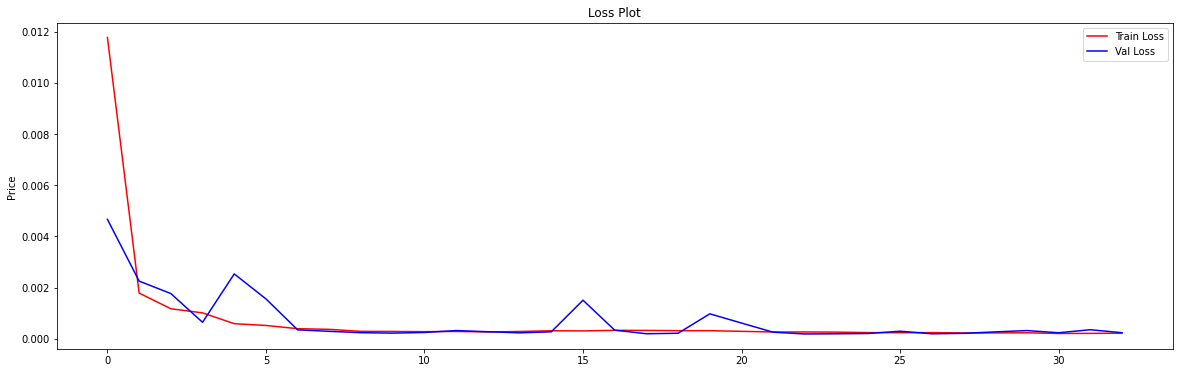

In [0]:
performance_df_ = pd.DataFrame(performance_df)

plt.figure(figsize=(20, 6))
plt.plot(performance_df_.train_loss, color='r', label="Train Loss") 
plt.plot(performance_df_.val_loss, color='b', label="Val Loss")
plt.ylabel("Price")
plt.title("Loss Plot")
plt.legend()
plt.show()

In [0]:
# loading best model
model.load_state_dict(torch.load(early_st.checkpoint_path))

<All keys matched successfully>

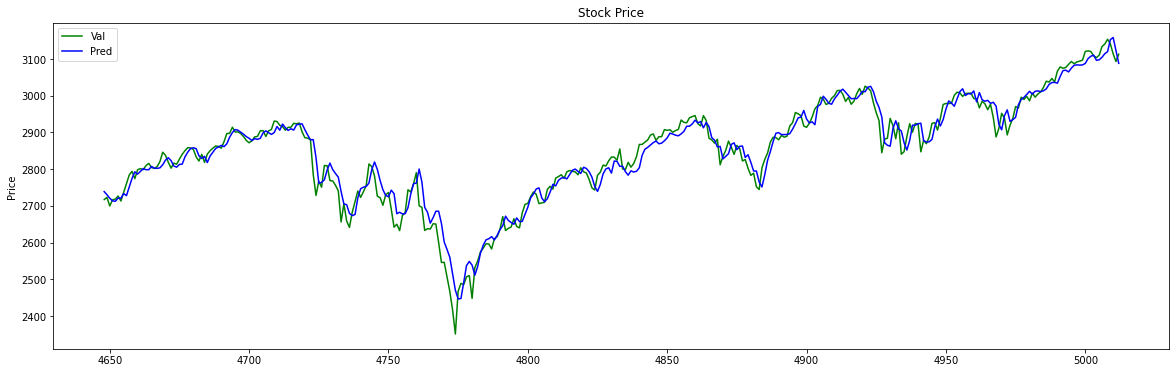

Validation Metrics
Accuracy: 98.90081882476807
RMAE: 4.62566742076475
RMSE: 29.913892130293117
MAPE: 0.012081993190804496
Avg Change 2.4900805950164795
Direction Accuracy 0.5068493150684932


In [0]:


losses, preds, true, indexes = predict(model=model, dataloader=valid_dataloader, device=device, criterion=criterion)
df_preds = inverse_scaling(true, preds, indexes)
df_preds = df_preds.sort_values(by='ind')
df_preds = df_preds.set_index('ind')

plt.figure(figsize=(20, 6))
# plt.plot(df_tr_preds.true, color='r', label="Train")

plt.plot(df_preds.true, color='g', label="Val") 
plt.plot(df_preds.pred, color='b', label="Pred") 

plt.ylabel("Price")
plt.title("Stock Price")
plt.legend()
plt.show()


print("Validation Metrics")
print("Accuracy:", calculate_accuracy(df_preds.true, df_preds.pred))
print("RMAE:", mean_absolute_error(df_preds.true, df_preds.pred)**.5)
print("RMSE:", mean_squared_error(df_preds.true, df_preds.pred)**.5)
print("MAPE:", mean_absolute_percentage_error(df_preds.true, df_preds.pred))
df_preds['change'] = df_preds.pred -  df_preds.true
print("Avg Change", df_preds.change.mean())
print("Direction Accuracy", accuracy_score(df_preds.true - df_preds.true.shift(1) > 0, df_preds.pred - df_preds.pred.shift(1) > 0))

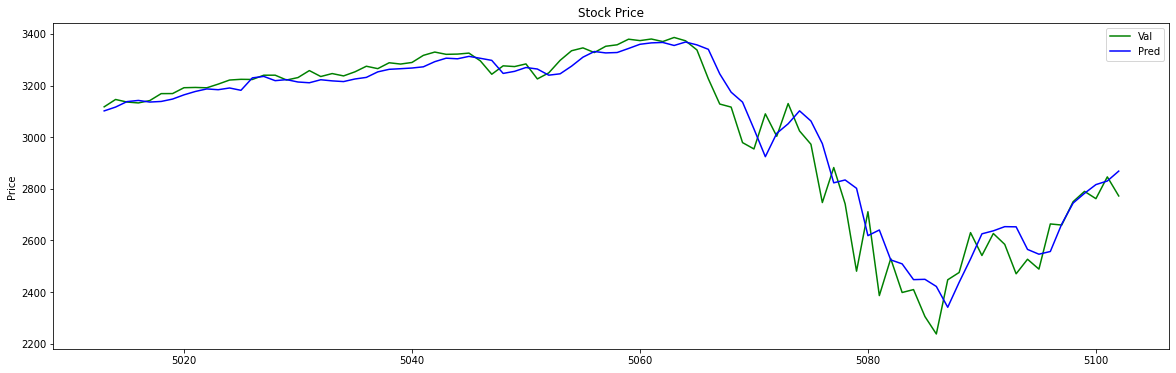

test Metrics
Accuracy: 97.00476005673409
RMAE: 7.1902988457681705
RMSE: 78.35351579540001
MAPE: 0.08971462375484407
Avg Change 10.897249221801758
Direction Accuracy 0.5222222222222223


In [0]:
losses, preds, true, indexes = predict(model=model, dataloader=test_dataloader, device=device, criterion=criterion)
df_preds = inverse_scaling(true, preds, indexes)
df_preds = df_preds.sort_values(by='ind')
df_preds = df_preds.set_index('ind')

plt.figure(figsize=(20, 6))
# plt.plot(df_tr_preds.true, color='r', label="Train")

plt.plot(df_preds.true, color='g', label="Val") 
plt.plot(df_preds.pred, color='b', label="Pred") 

plt.ylabel("Price")
plt.title("Stock Price")
plt.legend()
plt.show()


print("test Metrics")
print("Accuracy:", calculate_accuracy(df_preds.true, df_preds.pred))
print("RMAE:", mean_absolute_error(df_preds.true, df_preds.pred)**.5)
print("RMSE:", mean_squared_error(df_preds.true, df_preds.pred)**.5)
print("MAPE:", mean_absolute_percentage_error(df_preds.true, df_preds.pred))
df_preds['change'] = df_preds.pred -  df_preds.true
print("Avg Change", df_preds.change.mean())
print("Direction Accuracy", accuracy_score(df_preds.true - df_preds.true.shift(1) > 0, df_preds.pred - df_preds.pred.shift(1) > 0))

In [0]:
df_vl_nf = df_vl_preds.copy(deep=True)
df_vl_nf['pred'] = df_vl_nf['true'].shift(1)
df_vl_nf = df_vl_nf.dropna()

print("NF Validation RMAE:", mean_absolute_error(df_vl_nf.true, df_vl_nf.pred)**.5)
print("NF Validation RMSE:", mean_squared_error(df_vl_nf.true, df_vl_nf.pred)**.5)
print("NF Validation MAPE:", mean_absolute_percentage_error(df_vl_nf.true, df_vl_nf.pred))
df_vl_preds['change'] = df_vl_nf.pred -  df_vl_nf.true
print("NF Avg Change", df_vl_nf.change.mean())
print("NF Direction Accuracy", accuracy_score(df_vl_nf.true - df_vl_nf.true.shift(1) > 0, df_vl_nf.pred - df_vl_nf.pred.shift(1) > 0))

NF Validation RMAE: 4.234848164940809
NF Validation RMSE: 25.382560017211496
NF Validation MAPE: 0.008577485277783126
NF Avg Change -1.0870603322982788
NF Direction Accuracy 0.5384615384615384
